In [1]:
import baostock as bs
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [2]:
lg = bs.login()
print(f'login respond code: {lg.error_code}')
print(f'login respond msg: {lg.error_msg}')
params = ','.join(['date', 'open', 'high', 'low', 'close', 'preclose','volume','amount','turn', 'tradestatus', 'pctChg'])

login success!
login respond code: 0
login respond msg: success


In [3]:
def query_history_k_data_plus_with_df(**kwargs) -> pd.DataFrame:
    rs = bs.query_history_k_data_plus(**kwargs)
    data_list = []
    if rs.error_code!='0':
        raise Exception(f'error in fetch message: {rs.error_msg}')
    while rs.error_code == '0' and rs.next():
        data_list.append(rs.get_row_data())
    return pd.DataFrame(data_list, columns=rs.fields)

In [4]:
def fill_suspension(raw_df: pd.DataFrame, start_date: str, end_date: str) -> pd.DataFrame:
    start = datetime.strptime(start_date,'%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    date_counter = dict()
    columns = raw_df.columns.tolist()
    date_index = columns.index('date')
    close_index = columns.index('close')
    for r in raw_df.values:
        date_counter[r[date_index]] = list(r)
    first_record = raw_df.iloc[0]
    first_date = datetime.strptime(first_record['date'],'%Y-%m-%d')
    current = start
    last_close = first_record['close']
    while current < first_date:
        current_str = current.strftime('%Y-%m-%d')
        date_counter[current_str] = [current_str,last_close, last_close, last_close,last_close,last_close,0,0.0,0.0,0,0.0]
        current = current + timedelta(days=1)
    while current <= end:
        current_str = current.strftime('%Y-%m-%d')
        if date_counter.get(current_str) is None:
            last_day_str = (current + timedelta(days=-1)).strftime('%Y-%m-%d')
            last = date_counter.get(last_day_str) 
            last_close = last[close_index]
            date_counter[current_str] = [current_str,last_close, last_close, last_close,last_close,last_close,0,0.0,0.0,0,0.0] 
        current = current + timedelta(days=1)
    new_data = sorted(date_counter.values(),key=lambda x: x[date_index])
    return pd.DataFrame(new_data,columns=columns)

In [5]:
import os
import csv

def load_history_k_data_plus_with_df(**kwargs) -> pd.DataFrame:
    code = kwargs.get('code')
    frequency = kwargs.get('frequency')
    adjust = kwargs.get('adjustflag')
    path = os.path.join('.','resources',f'{code}-{frequency}-{adjust}.csv')
    if not os.path.exists(path):
        rs = query_history_k_data_plus_with_df(**kwargs)
        rs = fill_suspension(rs, kwargs.get('start_date'), kwargs.get('end_date'))
        rs.to_csv(path, index=False, encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)
    rs = pd.read_csv(path, quoting=csv.QUOTE_NONNUMERIC)
    return rs

In [6]:

start_date = '2006-01-01'
end_date = '2019-10-20'

In [7]:
# back adjust
#rs_ba = load_history_k_data_plus_with_df(code="sh.000001",start_date=start_date, end_date=end_date,fields=params,frequency='d', adjustflag = '1')
# front adjust
#rs_fa = load_history_k_data_plus_with_df(code="sh.000001",start_date=start_date, end_date=end_date,fields=params,frequency='d', adjustflag = '2')
# no adjust
rs_no  = load_history_k_data_plus_with_df(code="sh.000001",start_date=start_date, end_date=end_date,fields=params,frequency='d', adjustflag = '3')

In [8]:
rs_no.head()

,date,open,high,low,close,preclose,volume,amount,turn,tradestatus,pctChg
0,2006-01-04,1163.878,1181.004,1161.906,1180.963,1161.057,2.325854e+09,1.197043e+10,0.015049,1.0,1.714473
1,2006-01-05,1183.305,1197.837,1180.451,1197.269,1180.963,2.948448e+09,1.476720e+10,0.019075,1.0,1.380740
2,2006-01-06,1198.811,1215.536,1191.614,1209.422,1197.269,3.434286e+09,1.713047e+10,0.022207,1.0,1.015056
3,2006-01-09,1210.320,1217.314,1205.248,1215.668,1209.422,2.870666e+09,1.420640e+10,0.018558,1.0,0.516443
4,2006-01-10,1215.848,1220.756,1203.651,1220.618,1215.668,2.679455e+09,1.349637e+10,0.017307,1.0,0.407190


In [9]:
rs_all = rs_no

In [10]:
rs_all.head()

,date,open,high,low,close,preclose,volume,amount,turn,tradestatus,pctChg
0,2006-01-04,1163.878,1181.004,1161.906,1180.963,1161.057,2.325854e+09,1.197043e+10,0.015049,1.0,1.714473
1,2006-01-05,1183.305,1197.837,1180.451,1197.269,1180.963,2.948448e+09,1.476720e+10,0.019075,1.0,1.380740
2,2006-01-06,1198.811,1215.536,1191.614,1209.422,1197.269,3.434286e+09,1.713047e+10,0.022207,1.0,1.015056
3,2006-01-09,1210.320,1217.314,1205.248,1215.668,1209.422,2.870666e+09,1.420640e+10,0.018558,1.0,0.516443
4,2006-01-10,1215.848,1220.756,1203.651,1220.618,1215.668,2.679455e+09,1.349637e+10,0.017307,1.0,0.407190


In [11]:
window_size = 40
dataset = rs_all.set_index('date')
dataset['window_high'] = dataset['high'].rolling(window_size).max()
dataset['window_low'] = dataset['low'].rolling(window_size).max()
dataset['predict'] = dataset['close'].shift(-1)
dataset['trend'] = (dataset['predict']-dataset['close']).apply(lambda x: x>=0)
dataset['range'] = dataset['high'] - dataset['low']
dataset['window_range'] = dataset['window_high'] - dataset['window_low']
dataset = dataset.dropna(axis=0)
dataset.head()

,open,high,low,close,preclose,volume,amount,turn,tradestatus,pctChg,window_high,window_low,predict,trend,range,window_range
date,,,,,,,,,,,,,,,,
2006-03-09,1247.462,1253.758,1242.681,1245.166,1250.384,1.538593e+09,7.572686e+09,0.009534,1.0,-0.417313,1308.196,1297.763,1245.653,True,11.077,10.433
2006-03-10,1245.188,1253.911,1240.751,1245.653,1245.166,1.409563e+09,7.034995e+09,0.008724,1.0,0.039106,1308.196,1297.763,1259.674,True,13.160,10.433
2006-03-13,1245.300,1260.071,1245.300,1259.674,1245.653,1.377515e+09,6.762688e+09,0.008516,1.0,1.125594,1308.196,1297.763,1259.044,False,14.771,10.433
2006-03-14,1260.422,1262.752,1250.277,1259.044,1259.674,1.487571e+09,7.156890e+09,0.009189,1.0,-0.050013,1308.196,1297.763,1274.812,True,12.475,10.433
2006-03-15,1259.231,1275.515,1258.146,1274.812,1259.044,1.845127e+09,9.402430e+09,0.011384,1.0,1.252384,1308.196,1297.763,1274.190,False,17.369,10.433


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

In [13]:
label_columns = ['predict', 'trend']
trend_column = 'trend'
predict_column = 'predict'
x_columns = list(set(dataset.columns.to_list())-set(label_columns))
x_train, x_test, trend_train, trend_test = train_test_split(dataset[x_columns],dataset[trend_column], test_size=0.8, random_state=0)
_, _, pred_train, pred_test = train_test_split(dataset[x_columns],dataset[predict_column], test_size=0.8, random_state=0)

In [14]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
x_train

array([[-0.57280191, -0.10502166, -0.04736488, ...,  0.        ,
        -0.6168604 , -0.70032173],
       [ 2.13369948, -0.16459974,  5.80355449, ...,  0.        ,
         2.51309174,  2.86200326],
       [-1.0368879 , -0.25218016, -0.51928964, ...,  0.        ,
        -1.04207076, -1.02429578],
       ...,
       [-0.9057884 , -0.24526374, -0.34520886, ...,  0.        ,
        -0.90535123, -1.01763116],
       [ 0.55484358, -0.23645726, -0.66094604, ...,  0.        ,
         0.51492606,  0.23624172],
       [ 0.35212434, -0.25558816, -0.58077637, ...,  0.        ,
         0.33290537,  0.27378131]])

In [78]:
import lightgbm as gbm
train_data = gbm.Dataset(x_train, label=trend_train)
validation_data = gbm.Dataset(x_test, label=trend_test)
params={
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':4,
    'inbalance':'true',
    'objective': 'binary'
}
clf = gbm.train(params, train_data, valid_sets=[validation_data])
trend_pred = clf.predict(x_test)>=0.5
print(classification_report(trend_test, trend_pred))

[1]	valid_0's binary_logloss: 0.689674
[2]	valid_0's binary_logloss: 0.689558
[3]	valid_0's binary_logloss: 0.689475
[4]	valid_0's binary_logloss: 0.689388
[5]	valid_0's binary_logloss: 0.689387
[6]	valid_0's binary_logloss: 0.689341
[7]	valid_0's binary_logloss: 0.689354
[8]	valid_0's binary_logloss: 0.689344
[9]	valid_0's binary_logloss: 0.689374
[10]	valid_0's binary_logloss: 0.689364
[11]	valid_0's binary_logloss: 0.689382
[12]	valid_0's binary_logloss: 0.689392
[13]	valid_0's binary_logloss: 0.689425
[14]	valid_0's binary_logloss: 0.689453
[15]	valid_0's binary_logloss: 0.689439
[16]	valid_0's binary_logloss: 0.689502
[17]	valid_0's binary_logloss: 0.689569
[18]	valid_0's binary_logloss: 0.689629
[19]	valid_0's binary_logloss: 0.68969
[20]	valid_0's binary_logloss: 0.689793
[21]	valid_0's binary_logloss: 0.689805
[22]	valid_0's binary_logloss: 0.689918
[23]	valid_0's binary_logloss: 0.689936
[24]	valid_0's binary_logloss: 0.690083
[25]	valid_0's binary_logloss: 0.69015
[26]	valid_

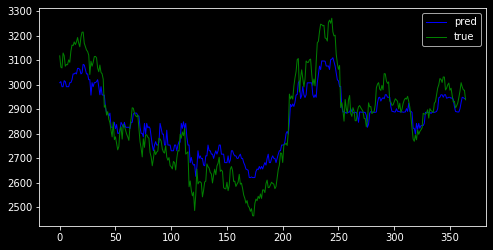

In [114]:
from matplotlib import pyplot as plt
points = 365
train_reg_data = gbm.Dataset(x_train, label=pred_train)
validation_reg_data = gbm.Dataset(x_test, label=pred_test)
params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
}
clf = gbm.train(params,train_reg_data, valid_sets=[validation_reg_data])
pred_pred = clf.predict(x_test)
plt.figure(figsize=(8,4))
preds = clf.predict(scaler.transform(dataset[x_columns]))
trues = dataset[predict_column].tolist()
plt.plot(range(points),preds[-points:],'b-',label='pred',linewidth=1)
plt.plot(range(points),trues[-points:],'g-',label='true', linewidth=1)
plt.legend()

In [115]:
from sklearn.metrics import mean_squared_error
print(f"mean squared error: {mean_squared_error(preds, trues)}")

mean squared error: 89581.71448950286
